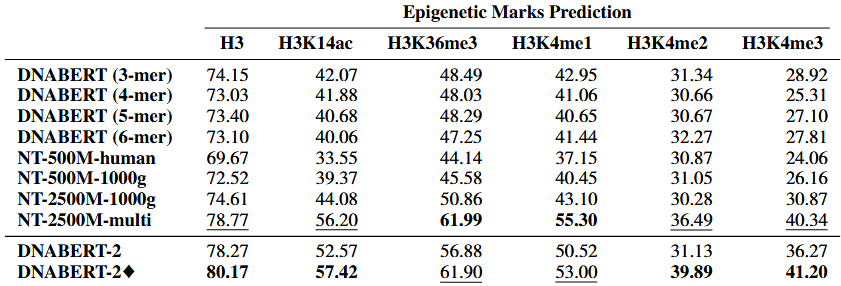

In [1]:
# standard libraries
import math
import os
import tempfile
from pathlib import Path
import json
import sys
import pickle
from pprint import pprint
import copy

# standard scientific libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import numpy as np
from numpy import asarray, save, load
import pandas as pd
import seaborn as sns

# tensorflow
import tensorflow as tf
import tensorflow_addons as tfa
import keras
from keras.models import load_model
from keras.utils import to_categorical, plot_model

# torch
import torch

# huggingface
from transformers import BertForSequenceClassification, PreTrainedTokenizerFast, AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from datasets import load_dataset
import evaluate

# scikit-learn
from sklearn.metrics import accuracy_score, precision_score, average_precision_score, recall_score, matthews_corrcoef, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, multilabel_confusion_matrix
from sklearn.utils.multiclass import unique_labels

2024-08-12 10:32:22.245166: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/mimer/NOBACKUP/groups/naiss2024-5-16/tloop/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/mimer/NOBACKUP/groups/naiss2024-5-16/tloop/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons sup

In [2]:
# Metrics

def get_metrics(labels, predictions):
    metrics = {}

    classes = unique_labels(labels)
    
    if len(classes) <= 2:
        average = "binary"
        
        # ROC
        metrics["auc"] = roc_auc_score(labels, predictions)
        fpr, tpr, _ = roc_curve(labels.argmax(axis=1), predictions[:,1])  # fpr=false positive rate = fp/(fp+tn), tpr=true positive rate = tp/(tp+fn)
        metrics["fpr"], metrics["tpr"] = fpr, tpr
    else:
        average = None
        
        # ROC OVR
        # metrics["auc"] = roc_auc_score(labels, predictions, multi_class='ovr', average=None)
        aucs, fprs, tprs = [], [], []
        for index, class_name in enumerate(classes):
            try:                aucs += [roc_auc_score(labels[:,index], predictions[:,index])]
            except ValueError:  aucs += ["N/A"]
            fpr, tpr, _ = roc_curve(labels[:,index], predictions[:,index])
            fprs += [fpr]; tprs += [tpr]
        metrics["auc"], metrics["fpr"], metrics["tpr"] = aucs, fprs, tprs
    
    labels, predictions = labels.argmax(axis=1), predictions.argmax(axis=1)
    
    metrics["confusion_matrix"] = confusion_matrix(labels, predictions)
    metrics["accuracy"] = accuracy_score(labels, predictions)
    metrics["precision"] = precision_score(labels, predictions, average=average)
    metrics["recall"] = recall_score(labels, predictions, average=average)
    metrics["f1"] = f1_score(labels, predictions, average=average)
    metrics["mcc"] = matthews_corrcoef(labels, predictions)

    return metrics

In [3]:
# Tensorflow functions

def get_tf_labels_features(data_path, num_classes):
    matrices = np.load(data_path, allow_pickle=True)
    features = np.stack(matrices['arr_0'], axis=0)
    data_name = data_path.stem.split("_")[0]
    labels = np.load(data_path.parents[0]/f"{data_name}_labels.npy", allow_pickle=True)
    labels = to_categorical(labels, num_classes=num_classes)
    return labels, features


def get_tf_model(model_dir):
    model = load_model(model_dir, custom_objects={'f1': tfa.metrics.F1Score, 'mcc': tfa.metrics.MatthewsCorrelationCoefficient})
    return model


def get_tf_predictions(model, features, batch_size):
    predictions = model.predict(features, batch_size = batch_size)
    return predictions


# def get_tf_metrics(labels, predictions):
    # metrics = model.evaluate(features, labels, verbose=0) # batch_size=batch_size
    # metrics = dict(zip(model.metrics_names, metrics))
    # return metrics


def get_tf_loss(path):
    with open(path, "rb") as file:
        history = pickle.load(file)
        loss = history["loss"]
        eval_loss = history["val_loss"]
    loss_dict = {"epoch": list(range(len(loss))), "loss": loss, "eval_loss": eval_loss}
    return loss_dict


def stats_tensorflow(DATA_PATH, MODEL_DIR, NUM_CLASSES, BATCH_SIZE = 16):
    labels, features = get_tf_labels_features(DATA_PATH, NUM_CLASSES)
    model = get_tf_model(MODEL_DIR)
    predictions = get_tf_predictions(model, features, BATCH_SIZE)
    metrics = get_metrics(labels, predictions) # TODO set lowest loss
    loss = get_tf_loss(MODEL_DIR/"history")

    return metrics, loss

In [4]:
# PyTorch functions

def get_torch_labels_features(data_path, num_classes):
    data = pd.read_csv(data_path)
    labels = list(data['label'])
    labels = to_categorical(labels, num_classes=num_classes)
    features = list(data['sequence'])
    return labels, features


def get_torch_model_tokenizer(model_dir):
    model = AutoModelForSequenceClassification.from_pretrained(model_dir, trust_remote_code=True)
    tokenizer = AutoTokenizer.from_pretrained(model_dir, trust_remote_code=True)
    return model, tokenizer


def get_torch_predictions(model, tokenizer, features): 
    
    # Tokenize texts and convert to tensors
    input = tokenizer(features, padding="longest", truncation=True, return_tensors='pt', max_length=tokenizer.model_max_length)
    
    # Forward pass to get predictions
    with torch.no_grad(): # Disabling gradient calculation, useful for inference
        output = model(**input)
        logits = output.logits
    
    # Get predicted probabilities
    predictions = torch.softmax(logits, dim=1).numpy()
    
    return predictions


# def get_torch_metrics(path): 
#     with open(path, "r") as file:
#         eval = json.load(file)
#     metrics = {
#             "loss": eval["eval_loss"],
#             "accuracy": eval["eval_accuracy"],
#             "precision": eval["eval_precision"],
#             "recall": eval["eval_recall"],
#             "f1": eval["eval_f1"],
#             "mcc": eval["eval_matthews_correlation"]}
#     return metrics


def get_torch_loss(path):
    with open(path, "r") as file:
        trainer_state = json.load(file)
    log_history = trainer_state["log_history"]
    loss = [log["loss"] for log in log_history[1::3]]
    epoch = [log["epoch"] for log in log_history[2::3]]
    eval_loss = [log["eval_loss"] for log in log_history[2::3]]
    loss_dict = {"epoch": epoch, "loss": loss, "eval_loss": eval_loss}
    return loss_dict


def stats_pytorch(DATA_PATH, MODEL_DIR, NUM_CLASSES):
    labels, features = get_torch_labels_features(DATA_PATH, NUM_CLASSES)
    model, tokenizer = get_torch_model_tokenizer(MODEL_DIR)
    predictions = get_torch_predictions(model, tokenizer, features)
    metrics = get_metrics(labels, predictions) # TODO add minimum loss
    loss = get_torch_loss(MODEL_DIR/"trainer_state.json")
    
    return metrics, loss

In [7]:
# Tensorflow loop

DATA_DIRS = Path("../data_generation/training_data/homology_reduced/")
MODEL_DIRS = Path("results/ANN/homology_reduced/")

ann_model_data = {}

for data_dir in sorted(os.listdir(DATA_DIRS)):
    if os.path.isfile(DATA_DIRS/data_dir): continue
    if data_dir[-1] == "U": continue
    if "gnravall" in data_dir: continue
    
    DATA_PATH = DATA_DIRS/data_dir/"test_matrices.npz"
    MODEL_DIR = MODEL_DIRS/data_dir

    if "clusters" in data_dir:  NUM_CLASSES = 24
    else:                       NUM_CLASSES = 2

    TITLE = data_dir; print(TITLE)
    
    metrics, loss = stats_tensorflow(DATA_PATH, MODEL_DIR, NUM_CLASSES)
    ann_model_data[TITLE] = {"metrics": metrics, "loss": loss}

gnra_24
4/4 [==============================] - 0s 2ms/step
gnra_8
2/2 [==============================] - 0s 2ms/step


In [6]:
# PyTorch loop

DATA_DIRS = Path("../data_generation/training_data/homology_reduced/")
MODEL_DIRS = Path("results/DNABERT2/alvis/tetraloop/homology_reduced") # TODO separate between homology reduced and non

dnabert2_model_data = {}

for data_dir in sorted(os.listdir(DATA_DIRS)):
    if os.path.isfile(DATA_DIRS/data_dir): continue
    if "gnravall" in data_dir: continue

    DATA_PATH = DATA_DIRS/data_dir/"test.csv"
    TITLE = data_dir; print(TITLE)

    if "clusters" in data_dir:  NUM_CLASSES = 24
    else:                       NUM_CLASSES = 2

    best_metrics, best_loss = {}, {}

    for seed in range(1,4): # Take best model from seeds 1-3
        MODEL_DIR = MODEL_DIRS/(data_dir + f"_{seed}")
        print(MODEL_DIR)
        metrics, loss = stats_pytorch(DATA_PATH, MODEL_DIR, NUM_CLASSES)
        if not best_metrics:
            best_metrics, best_loss = metrics, loss
        elif min(loss["loss"]) < min(best_loss["loss"]):
            best_metrics, best_loss = metrics, loss
    
    dnabert2_model_data[TITLE] = {"metrics": best_metrics, "loss": best_loss}

gnra_24
results/DNABERT2/alvis/tetraloop/homology_reduced/gnra_24_1


OSError: results/DNABERT2/alvis/tetraloop/homology_reduced/gnra_24_1 does not appear to have a file named config.json. Checkout 'https://huggingface.co/results/DNABERT2/alvis/tetraloop/homology_reduced/gnra_24_1/None' for available files.

In [8]:
# Save results
with open("results/ann_results_homology_reduced", 'wb') as file:
    pickle.dump(ann_model_data, file)

with open("results/dnabert2_results_homology_reduced", 'wb') as file:
    pickle.dump(dnabert2_model_data, file)

In [9]:
# Load results
with open("results/ann_results_homology_reduced", 'rb') as file:
    ann_model_data = pickle.load(file)

with open("results/dnabert2_results_homology_reduced", 'rb') as file:
    dnabert2_model_data = pickle.load(file)

In [10]:
# Config

# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('seaborn-darkgrid')

colors = plt.cm.Set2.colors + plt.cm.Accent.colors

custom_cycler = (plt.cycler(linestyle=['-', 'dotted']) * plt.cycler(color=colors))
plt.rcParams["axes.prop_cycle"] = custom_cycler

figures_dir = Path("figures/homology_reduced")

In [11]:
def plot_confusion_matrices(confusion_matrices, titles, labels = [], plot_title = "", n_cols = 3, fig_height = 2.5, fig_width = 2.5, cbar_shrink = 0.75):
    n_rows = math.ceil(len(confusion_matrices) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width*n_cols, fig_height*n_rows), dpi=300)
    fig.suptitle(plot_title)
    
    for idx, matrix in enumerate(confusion_matrices):
        ax = axes[idx // n_cols][idx % n_cols] if type(axes) is np.ndarray else axes
        if labels: tick_labels = labels[idx]
        else: tick_labels = "auto"
        my_cmap = copy.copy(mpl.cm.get_cmap('magma'))
        my_cmap.set_bad(my_cmap.colors[0])
        # norm=LogNorm(), robust=True
        sns.heatmap(matrix, annot=True, fmt="d", ax=ax, xticklabels = tick_labels, yticklabels = tick_labels, square=True, norm=LogNorm(vmin=1), cbar_kws={"shrink": cbar_shrink}, cmap=my_cmap)
        
        ax.set_title(titles[idx])
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    
    for idx in range(len(confusion_matrices), n_cols * n_rows):
        fig.delaxes(axes[idx // n_cols][idx % n_cols])
        
    plt.tight_layout()


def split_confusion_matrix(confusion_matrix):
    confusion_matrices = []
    for idx in range(len(confusion_matrix)):
        tp = confusion_matrix[idx, idx]
        fn = confusion_matrix[idx,:].sum() - tp      # row across
        fp = confusion_matrix[:,idx].sum() - tp      # column down
        tn = confusion_matrix.sum() - tp - fn - fp   # rectangles
        confusion_matrices += [np.array([[tp, fn],[fp,tn]])]
    return confusion_matrices

In [12]:
def plot_losses(losses, titles, plot_title = "", legend_cols = 2,  legend_offset=1.35):
    fig, ax = plt.subplots(figsize=(7, 4), dpi=300)
    ax.set_title(plot_title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    
    for idx, loss_dict in enumerate(losses):
        ax.plot(loss_dict["epoch"], loss_dict["loss"], label=f'{titles[idx]} training', color = colors[idx])
        ax.plot(loss_dict["epoch"], loss_dict["eval_loss"], label=f'{titles[idx]} validation', color = colors[idx], linestyle="dotted")

    fig.legend(loc='center right', bbox_to_anchor=(legend_offset,0.5), title = "Length", ncol = legend_cols)

In [13]:
def plot_rocs(fprs, tprs, aucs, series_titles, plot_title = "", legend_cols = 1, legend_offset = 1.07, legend_title = "Length", **kwargs):
    fig, ax = plt.subplots(figsize=(6,4), dpi=300)
    ax.set_title(plot_title)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_xlim([-0.05,1.05]); ax.set_ylim([-0.05,1.05])
    ax.set_xticks([i/10 for i in range(11)]); ax.set_yticks([i/10 for i in range(11)])
    ax.set_aspect('equal', adjustable='box')
    
    ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random') # Random line
    
    for idx, auc in enumerate(aucs):
        if auc == "N/A": continue
        ax.plot(fprs[idx], tprs[idx], label=f'{series_titles[idx]} (AUC = {auc:.2f})' , linewidth=2, **kwargs)
    
    fig.legend(loc='center right', bbox_to_anchor=(legend_offset,0.5), ncol=legend_cols, title=legend_title)

TypeError: 'AxesSubplot' object is not subscriptable

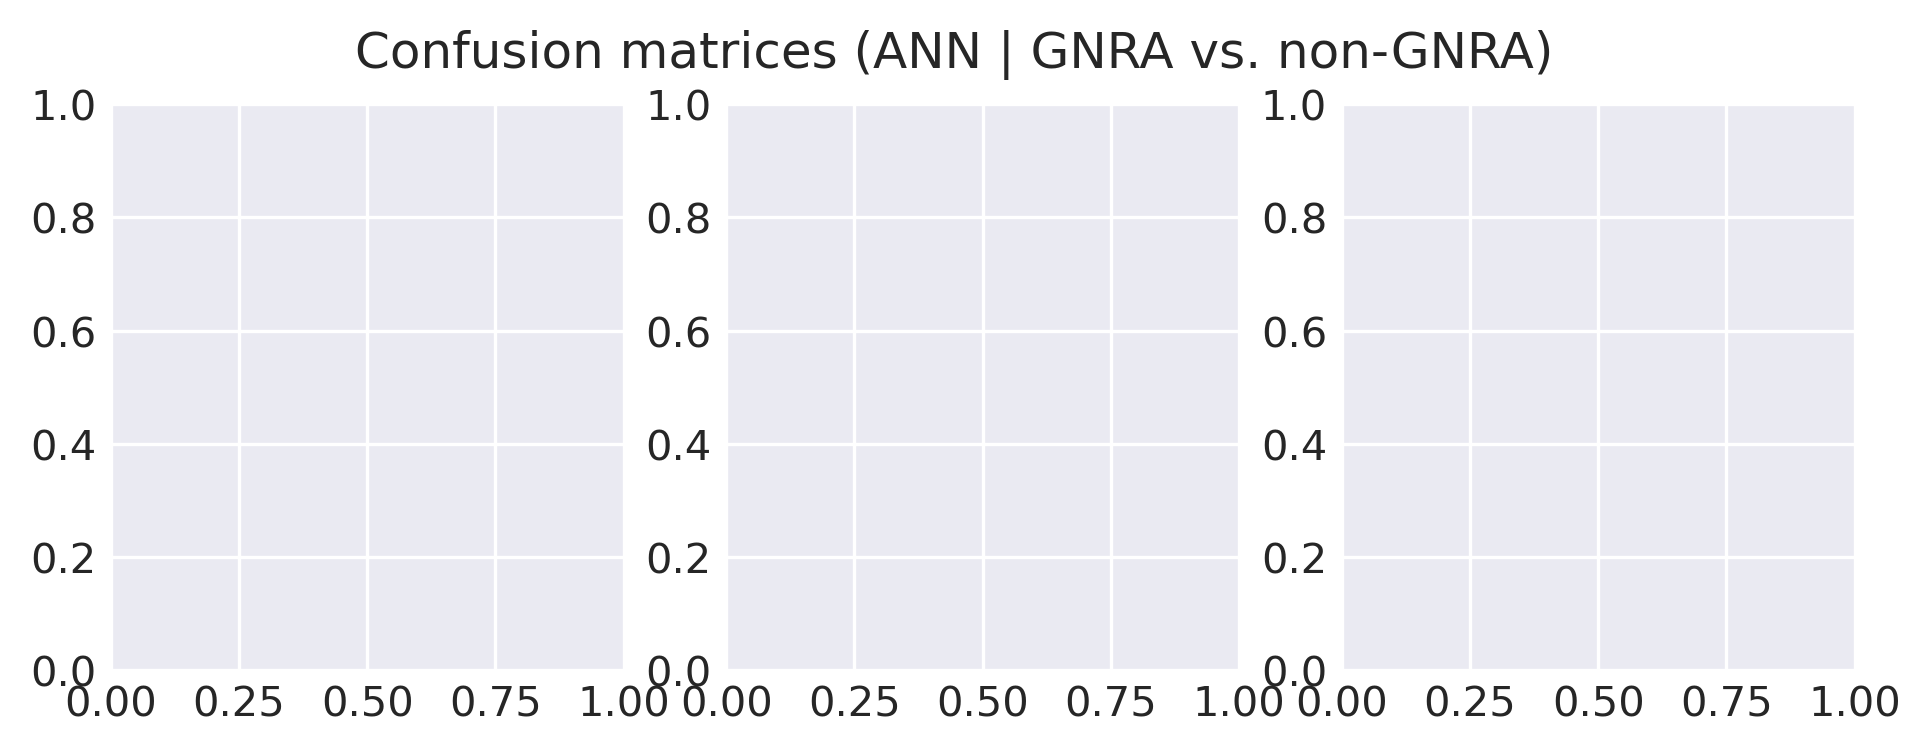

In [14]:
# GNRA vs. non-GNRA tetraloops (ANN)
PLOT_TITLE = "ANN | GNRA vs. non-GNRA"

items = dict(sorted([(title, data) for title, data in ann_model_data.items() if "gnra" in title], key=lambda x: int(x[0].split("_")[1])))
titles = [i.split("_")[1] for i in items.keys()]

confusion_matrices = [i["metrics"]["confusion_matrix"] for i in items.values()]
plot_confusion_matrices(confusion_matrices, [f"Length {i}" for i in titles], labels=[["non-GNRA", "GNRA"] for i in range(len(items))], plot_title=f"Confusion matrices ({PLOT_TITLE})")
plt.savefig(figures_dir/"ann_gnra_cm", bbox_inches="tight", dpi=300)

losses = [i["loss"] for i in items.values()]
plot_losses(losses, titles, plot_title=f"Loss ({PLOT_TITLE})")
plt.savefig(figures_dir/"ann_gnra_loss", bbox_inches="tight", dpi=300)

fprs = [i["metrics"]["fpr"] for i in items.values()]
tprs = [i["metrics"]["tpr"] for i in items.values()]
aucs = [i["metrics"]["auc"] for i in items.values()]
plot_rocs(fprs, tprs, aucs, titles, plot_title=f"ROC curves ({PLOT_TITLE})")
plt.savefig(figures_dir/"ann_gnra_roc", bbox_inches="tight", dpi=300)

print("Length  Accuracy  Precision  Recall  F1    MCC")
for idx, i in enumerate(items.values()):
    metrics = i["metrics"]
    print(f'{titles[idx].split()[-1]:<8}{round(metrics["accuracy"], 2):<10}{round(metrics["precision"], 2):<11}{round(metrics["recall"], 2):<8}{round(metrics["f1"], 2):<6}{round(metrics["mcc"], 2)}')

In [15]:
#GNRA vs. non-GNRA tetraloops (DNABERT-2)
PLOT_TITLE = "DNABERT-2 | GNRA vs. non-GNRA"

items = dict(sorted([(title, data) for title, data in dnabert2_model_data.items() if "gnra" in title and "T" in title], key=lambda x: int(x[0].split("_")[1])))
titles = [i.split("_")[1] for i in items.keys()]

confusion_matrices = [i["metrics"]["confusion_matrix"] for i in items.values()]
plot_confusion_matrices(confusion_matrices, [f"Length {i}" for i in titles], labels=[["non-GNRA", "GNRA"] for i in range(len(items))], plot_title=f"Confusion matrices ({PLOT_TITLE})")
plt.savefig(figures_dir/"dnabert2_gnra_cm", bbox_inches="tight", dpi=300)

losses = [i["loss"] for i in items.values()]
plot_losses(losses, titles, plot_title=f"Loss ({PLOT_TITLE})")
plt.savefig(figures_dir/"dnabert2_gnra_loss", bbox_inches="tight", dpi=300)

fprs = [i["metrics"]["fpr"] for i in items.values()]
tprs = [i["metrics"]["tpr"] for i in items.values()]
aucs = [i["metrics"]["auc"] for i in items.values()]
plot_rocs(fprs, tprs, aucs, titles, plot_title=f"ROC curves ({PLOT_TITLE})")
plt.savefig(figures_dir/"dnabert2_gnra_roc", bbox_inches="tight", dpi=300)

print("Length  Accuracy  Precision  Recall  F1    MCC")
for idx, i in enumerate(items.values()):
    metrics = i["metrics"]
    print(f'{titles[idx].split()[-1]:<8}{round(metrics["accuracy"], 2):<10}{round(metrics["precision"], 2):<11}{round(metrics["recall"], 2):<8}{round(metrics["f1"], 2):<6}{round(metrics["mcc"], 2)}')

ValueError: Number of rows must be a positive integer, not 0

<Figure size 2250x0 with 0 Axes>

In [16]:
# Tetraloops vs. decoys (ANN)
PLOT_TITLE = "ANN | Tetraloops vs. decoys"

items = dict(sorted([(title, data) for title, data in ann_model_data.items() if "tloop" in title], key=lambda x: int(x[0].split("_")[1])))
titles = [i.split("_")[1] for i in items.keys()]

confusion_matrices = [i["metrics"]["confusion_matrix"] for i in items.values()]
plot_confusion_matrices(confusion_matrices, [f"Length {i}" for i in titles], labels=[["Decoy", "Tloop"] for i in range(len(items))], plot_title=f"Confusion matrices ({PLOT_TITLE})")
plt.savefig(figures_dir/"ann_tloop_cm", bbox_inches="tight", dpi=300)

losses = [i["loss"] for i in items.values()]
plot_losses(losses, titles, plot_title=f"Loss ({PLOT_TITLE})")
plt.savefig(figures_dir/"ann_tloop_loss", bbox_inches="tight", dpi=300)

fprs = [i["metrics"]["fpr"] for i in items.values()]
tprs = [i["metrics"]["tpr"] for i in items.values()]
aucs = [i["metrics"]["auc"] for i in items.values()]
plot_rocs(fprs, tprs, aucs, titles, plot_title=f"ROC curves ({PLOT_TITLE})")
#plt.savefig(figures_dir/"ann_tloop_roc", bbox_inches="tight", dpi=300)

print("Length  Accuracy  Precision  Recall  F1    MCC")
for idx, i in enumerate(items.values()):
    metrics = i["metrics"]
    print(f'{titles[idx].split()[-1]:<8}{round(metrics["accuracy"], 2):<10}{round(metrics["precision"], 2):<11}{round(metrics["recall"], 2):<8}{round(metrics["f1"], 2):<6}{round(metrics["mcc"], 2)}')

ValueError: Number of rows must be a positive integer, not 0

<Figure size 2250x0 with 0 Axes>

In [ ]:
# Tetraloops vs. decoys (DNABERT-2)
PLOT_TITLE = "DNABERT-2 | Tetraloops vs. decoys"

items = dict(sorted([(title, data) for title, data in dnabert2_model_data.items() if "tloop" in title and "T" in title], key=lambda x: int(x[0].split("_")[1])))
titles = [i.split("_")[1] for i in items.keys()]

confusion_matrices = [i["metrics"]["confusion_matrix"] for i in items.values()]
plot_confusion_matrices(confusion_matrices, [f"Length {i}" for i in titles], labels=[["Decoy", "Tloop"] for i in range(len(items))], plot_title=f"Confusion matrices ({PLOT_TITLE})")
plt.savefig(figures_dir/"dnabert2_tloop_cm", bbox_inches="tight", dpi=300)

losses = [i["loss"] for i in items.values()]
plot_losses(losses, titles, plot_title=f"Loss ({PLOT_TITLE})")
plt.savefig(figures_dir/"dnabert2_tloop_loss", bbox_inches="tight", dpi=300)

fprs = [i["metrics"]["fpr"] for i in items.values()]
tprs = [i["metrics"]["tpr"] for i in items.values()]
aucs = [i["metrics"]["auc"] for i in items.values()]
plot_rocs(fprs, tprs, aucs, titles, plot_title=f"ROC curves ({PLOT_TITLE})")
plt.savefig(figures_dir/"dnabert2_tloop_roc", bbox_inches="tight", dpi=300)

print("Length  Accuracy  Precision  Recall  F1    MCC")
for idx, i in enumerate(items.values()):
    metrics = i["metrics"]
    print(f'{titles[idx].split()[-1]:<8}{round(metrics["accuracy"], 2):<10}{round(metrics["precision"], 2):<11}{round(metrics["recall"], 2):<8}{round(metrics["f1"], 2):<6}{round(metrics["mcc"], 2)}')

: 

In [ ]:
# Clusters classification (ANN)
PLOT_TITLE = "ANN | Clusters classification"

items = dict(sorted([(title, data) for title, data in ann_model_data.items() if "cluster" in title], key=lambda x: int(x[0].split("_")[1])))
titles = [i.split("_")[1] for i in items.keys()]

confusion_matrix = [i["metrics"]["confusion_matrix"] for i in items.values()][-1]
plot_confusion_matrices([confusion_matrix], [""], n_cols=1, fig_width=14, fig_height=12, cbar_shrink=0.95, plot_title=f"Confusion matrices ({PLOT_TITLE} | Length 24)")
plt.savefig(figures_dir/"ann_clusters_cm", bbox_inches="tight", dpi=300)

losses = [i["loss"] for i in items.values()][-1]
plot_losses([losses], [24], plot_title=f"Loss ({PLOT_TITLE} | Length 24)", legend_cols=1, legend_offset=1.12)
plt.savefig(figures_dir/"ann_clusters_loss", bbox_inches="tight", dpi=300)

metrics = list(items.values())[-1]["metrics"]
plot_rocs(metrics["fpr"], metrics["tpr"], metrics["auc"], range(24), legend_cols=2, legend_offset=1.37, legend_title="Cluster", plot_title=f"ROC curves ({PLOT_TITLE} | Length 24)")
plt.savefig(figures_dir/"ann_clusters_roc", bbox_inches="tight", dpi=300)

for idx, i in enumerate(items.values()):
    print(titles[idx])
    metrics = i["metrics"]
    print(f"Accuracy\t{metrics['accuracy']:.2f}")
    print(f"MCC\t{metrics['mcc']:.2f}")
    for metric in ["precision", "recall", "f1"]:
        scores_str = "\t".join([str(round(i,2)) for i in metrics[metric]])
        print(f"{metric.capitalize()}\t{scores_str}")
    print()

: 

In [ ]:
# Clusters classification (DNABERT-2)
PLOT_TITLE = "DNABERT-2 | Clusters classification"

items = dict(sorted([(title, data) for title, data in dnabert2_model_data.items() if "cluster" in title and "T" in title], key=lambda x: int(x[0].split("_")[1])))
titles = [i.split("_")[1] for i in items.keys()]

confusion_matrix = [i["metrics"]["confusion_matrix"] for i in items.values()][-1]
plot_confusion_matrices([confusion_matrix], [""], n_cols=1, fig_width=14, fig_height=12, cbar_shrink=0.95, plot_title=f"Confusion matrices ({PLOT_TITLE} | Length 24)")
plt.savefig(figures_dir/"dnabert2_clusters_cm", bbox_inches="tight", dpi=300)

losses = [i["loss"] for i in items.values()][-1]
plot_losses([losses], [24], plot_title=f"Loss ({PLOT_TITLE} | Length 24)", legend_cols=1, legend_offset=1.12)
plt.savefig(figures_dir/"dnabert2_clusters_loss", bbox_inches="tight", dpi=300)

metrics = list(items.values())[-1]["metrics"]
plot_rocs(metrics["fpr"], metrics["tpr"], metrics["auc"], range(24), legend_cols=2, legend_offset=1.37, legend_title="Cluster", plot_title=f"ROC curves ({PLOT_TITLE} | Length 24)")
plt.savefig(figures_dir/"dnabert2_clusters_roc", bbox_inches="tight", dpi=300)

for idx, i in enumerate(items.values()):
    print(titles[idx])
    metrics = i["metrics"]
    print(f"Accuracy\t{metrics['accuracy']:.2f}")
    print(f"MCC\t{metrics['mcc']:.2f}")
    for metric in ["precision", "recall", "f1"]:
        scores_str = "\t".join([str(round(i,2)) for i in metrics[metric]])
        print(f"{metric.capitalize()}\t{scores_str}")
    print()

: 

In [ ]:
pprint(ann_model_data['gnra_8']['metrics'])
pprint(ann_model_data['gnra_24']['metrics'])

: 

In [ ]:
model = get_tf_model(Path("results/ANN/gnrareal_8_80_T"))

single_test = [
    [1,0,0,0,0],
    [0,0,1,0,0],
    [0,0,0,1,0],
    [0,1,0,0,0],
    [1,0,0,0,0],
    [1,0,0,0,0],
    [0,0,0,1,0],
    [0,0,0,1,0]]

model.predict(np.array([single_test]))[0]

: 